BoxPlots for All patients

In [54]:
#Import Modules

import sys
sys.path.append("..") #give this script access to all modules in parent directory
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scipy.io import loadmat
import scipy
import scipy.stats as stats
from scipy.stats import skew
from Data_Cleaning import Filtering
import Actigraph_Metrics

Define Functions

Load All Patient Data

In [26]:
#Patients with -2 or 2 are ['Patient13', 'Patient2', 'Patient3', 'Patient4', 'Patient9']
# data_dir = r'C:\Users\jakes\Documents\DT 6 Analysis\PythonCode\PedAccel\data_analysis\PythonPipeline\PatientData'
data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'
window_size = 100 #100 is 1 second worth of time
lead_time = 10
slice_size_min = 15
sr = .5

14
The work to go from neg1 to 0 is: 12.557777777777778
Statistic: 25.5, p-value: 0.12570678846187133
The work to go from 0 to 1 is: 29.9311111111111
The work to go from neg1 to 1 is: 18.57999999999999
Statistic: 0.0, p-value: 0.4


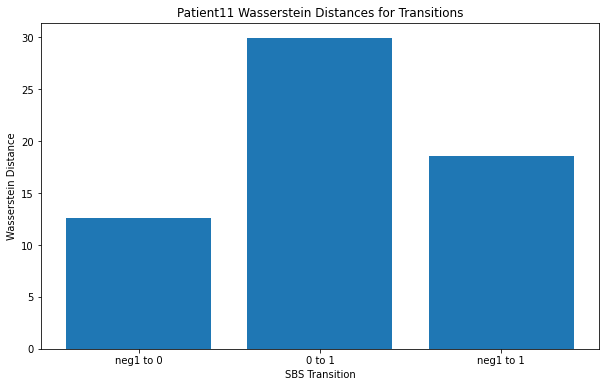

6
The work to go from neg1 to 0 is: 21.12222222222222
Statistic: 0.0, p-value: 0.3333333333333333
The work to go from 0 to 1 is: 8.773333333333326
The work to go from neg1 to 1 is: 29.895555555555546
Statistic: 0.0, p-value: 0.6666666666666666


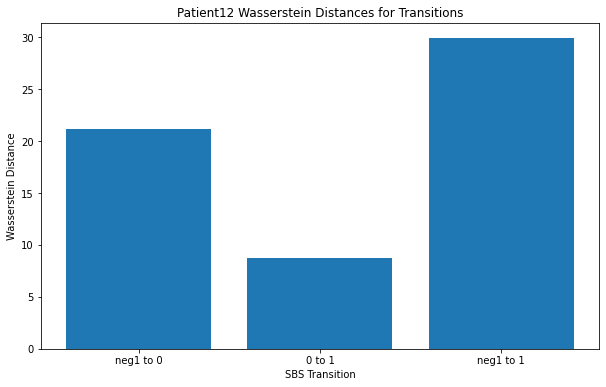

31
The work to go from neg1 to 0 is: 4.573703703703705
Statistic: 27.0, p-value: 1.0
The work to go from 0 to 1 is: 14.794814814814812
The work to go from 1 to 2 is: 28.144814814814815
The work to go from neg1 to 1 is: 14.221851851851849
Statistic: 14.0, p-value: 0.14465534465534466
The work to go from 0 to 2 is: 42.93962962962963
The work to go from neg1 to 2 is: 42.36666666666667
Statistic: 2.0, p-value: 0.0015984015984015984


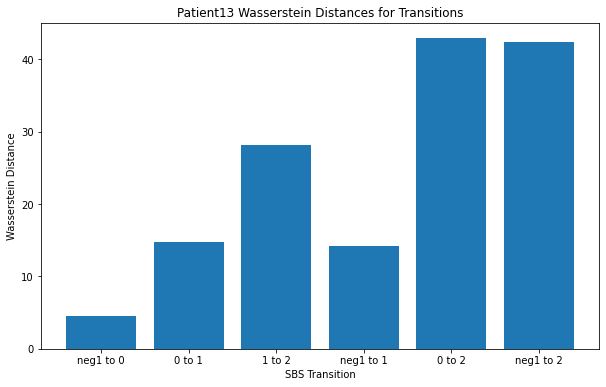

30
The work to go from neg1 to 0 is: 13.562564102564096
Statistic: 7.0, p-value: 0.380952380952381
The work to go from 0 to 1 is: 13.24663461538462
The work to go from 1 to 2 is: 16.38967592592593
The work to go from neg1 to 1 is: 22.84458333333333
Statistic: 1.0, p-value: 0.08888888888888889
The work to go from 0 to 2 is: 28.532678062678066
The work to go from neg1 to 2 is: 36.364814814814814
Statistic: 0.0, p-value: 0.2


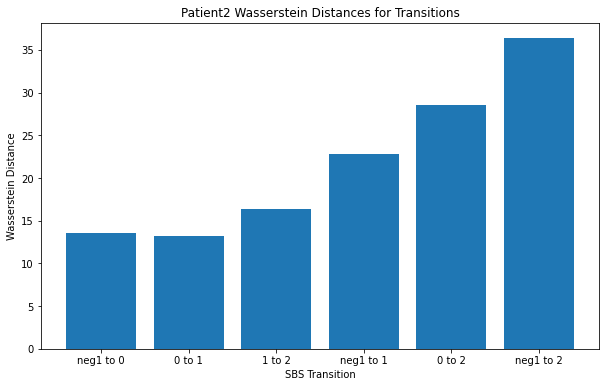

11
The work to go from neg1 to 0 is: 1.596666666666664
Statistic: 2.0, p-value: 1.0
The work to go from 0 to 1 is: 12.294888888888893
The work to go from neg1 to 1 is: 13.797333333333336
Statistic: 4.0, p-value: 0.8571428571428571


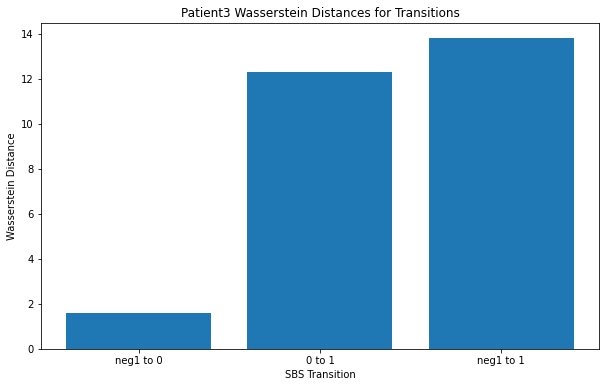

114
The work to go from neg1 to 0 is: 6.957114845938373
Statistic: 186.0, p-value: 0.24274873555018273
The work to go from 0 to 1 is: 2.067986928104578
The work to go from 1 to 2 is: 5.185021164021165
The work to go from neg1 to 1 is: 7.8016666666666685
Statistic: 206.0, p-value: 0.14684015911970988
The work to go from 0 to 2 is: 4.8013196389666986
The work to go from neg1 to 2 is: 8.396560846560849
Statistic: 140.0, p-value: 0.826754132769616


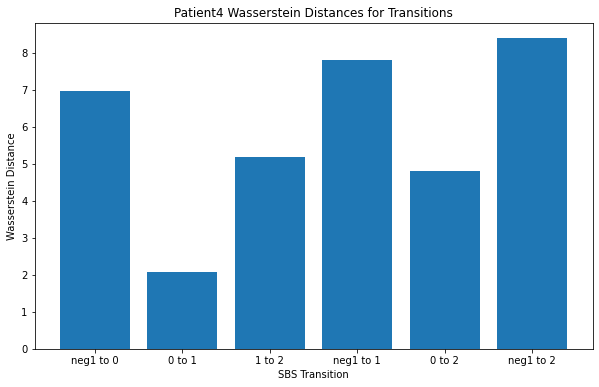

43
The work to go from neg1 to 0 is: 5.79893893893894
Statistic: 44.0, p-value: 0.5914979757085022
The work to go from 0 to 1 is: 16.058018018018014
The work to go from neg1 to 1 is: 17.190370370370363
Statistic: 0.0, p-value: 0.5


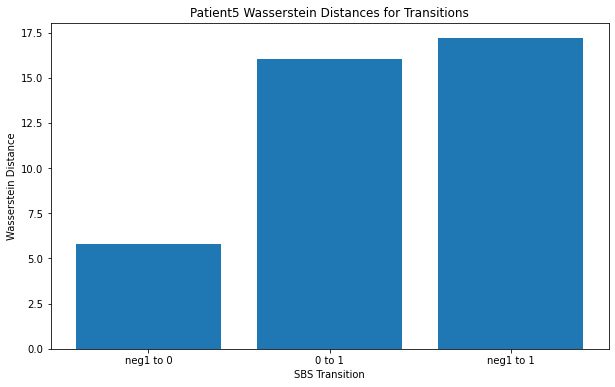

4
The work to go from neg1 to 0 is: 41.66444444444445
Statistic: 0.0, p-value: 0.6666666666666666


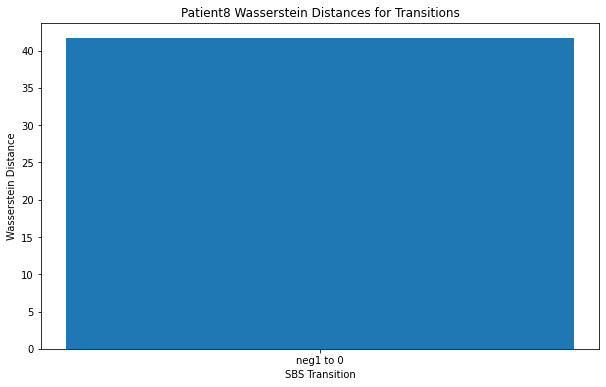

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData\\Patient9\\Patient9_10MIN_5MIN.mat'

In [60]:
from scipy.stats import wasserstein_distance 

#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')           
        data_filepath_vitals = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')
        
        accel_data = loadmat(data_filepath_accel)
        x_mag = accel_data["x_mag"]
        accel_SBS = accel_data["sbs"].flatten()
        
        vitals_data = loadmat(data_filepath_vitals)
        temp_hr = vitals_data['heart_rate']
        temp_SpO2 = vitals_data['SpO2']
        temp_rr = vitals_data['respiratory_rate']

        vitals_SBS = vitals_data['sbs'].flatten()
        hr = []
        rr = []
        SpO2 = []
        SBS_neg2 = []
        SBS_neg1 = []
        SBS_zero = []            
        SBS_one = []
        SBS_two = []
        vitals_list = [hr,rr,SpO2]
        vitals_names = ['hr','rr','spo2']
        temp_vitals = [temp_hr,temp_rr, temp_SpO2] 
        
        flag_list = [0] * (int)(sr * 60 * slice_size_min) #generate a list to insert in place of invalid data, 
        #this list serves as a flag for a window to ignore in the box plot function

        for j in range(len(vitals_list)): #go through every vitals metric
            #print(f'original {vitals_names[j]} vitals array shape: {np.array(temp_vitals[j]).shape} ')
            for i in range(len(vitals_SBS)): #go through every SBS score for each vitals metric
                if (Filtering.checkVitals(temp_vitals[j][i], slice_size_min, vitals_names[j])): #check the data in a single window
                    vitals_list[j].append(temp_vitals[j][i]) #append that single window data to the 2D hr,rr,spo2,bpm,bps,bpd arrays if that window's data is valid
                else:
                    vitals_list[j].append(flag_list) #append an array of zeros for window number i for the jth vitals metric if the data is invalid(i.e. too many NaN points)
                   # print(f'{vitals_names[j]} SBS index {i} has insufficient data, zeros appended in place') 
            #print(f'final {vitals_names[j]} vitals array shape: {np.array(vitals_list[j]).shape}') #should be the number of SBS scores by the number of samples in a win
        
        #go through HR
        # print(len(vitals_SBS))
        # for k in range(len(vitals_SBS) - 1):
        #     mean = np.mean(vitals_list[0][k]) 
        #     if mean != 0:
        #         if vitals_SBS[k] == -2:
        #             SBS_neg2.append(vitals_list[0][k])
        #         elif vitals_SBS[k] == -1:
        #             SBS_neg1.append(vitals_list[0][k])
        #         elif vitals_SBS[k] == 0:
        #             SBS_zero.append(vitals_list[0][k])           
        #         elif vitals_SBS[k] == 1:
        #             SBS_one.append(vitals_list[0][k])
        #         elif vitals_SBS[k] == 2:
        #             SBS_two.append(vitals_list[0][k])
        
        # print(len(accel_SBS))
        # for k in range(len(accel_SBS) - 1):
        #     mean = np.mean(x_mag[k]) 
        #     if mean != 0:
        #         if accel_SBS[k] == -2:
        #             SBS_neg2.append(x_mag[k, :])
        #         elif accel_SBS[k] == -1:
        #             SBS_neg1.append(x_mag[k, :])
        #         elif accel_SBS[k] == 0:
        #             SBS_zero.append(x_mag[k, :])           
        #         elif accel_SBS[k] == 1:
        #             SBS_one.append(x_mag[k, :])
        #         elif accel_SBS[k] == 2:
        #             SBS_two.append(x_mag[k, :])
        
        print(len(vitals_SBS))
        for k in range(len(vitals_SBS) - 1):
            mean = np.mean(vitals_list[0][k]) 
            if mean != 0:
                if vitals_SBS[k] == -2:
                    SBS_neg2.append(np.mean(vitals_list[0][k]))
                elif vitals_SBS[k] == -1:
                    SBS_neg1.append(np.mean(vitals_list[0][k]))
                elif vitals_SBS[k] == 0:
                    SBS_zero.append(np.mean(vitals_list[0][k]))           
                elif vitals_SBS[k] == 1:
                    SBS_one.append(np.mean(vitals_list[0][k]))
                elif vitals_SBS[k] == 2:
                    SBS_two.append(np.mean(vitals_list[0][k]))

    distances = []
    labels = []

    # -1 to 0
    print(f'The work to go from neg1 to 0 is: {wasserstein_distance(np.array(SBS_neg1).flatten(), np.array(SBS_zero).flatten(), u_weights=None, v_weights=None)}')
    distances.append(wasserstein_distance(np.array(SBS_neg1).flatten(), np.array(SBS_zero).flatten()))
    labels.append('neg1 to 0')
    result = stats.mannwhitneyu(np.array(SBS_neg1).flatten(), np.array(SBS_zero).flatten(), alternative='two-sided')
    print(f'Statistic: {result.statistic}, p-value: {result.pvalue}')
    
    # 0 to 1
    if len(np.array(SBS_zero)) != 0 and (len(np.array(SBS_one)) != 0):
        print(f'The work to go from 0 to 1 is: {wasserstein_distance(np.array(SBS_zero).flatten(), np.array(SBS_one).flatten(), u_weights=None, v_weights=None)}')
        distances.append(wasserstein_distance(np.array(SBS_zero).flatten(), np.array(SBS_one).flatten()))
        labels.append('0 to 1')
        
    # 1 to 2
    if len(np.array(SBS_one)) != 0 and (len(np.array(SBS_two)) != 0):
        print(f'The work to go from 1 to 2 is: {wasserstein_distance(np.array(SBS_one).flatten(), np.array(SBS_two).flatten(), u_weights=None, v_weights=None)}')
        distances.append(wasserstein_distance(np.array(SBS_one).flatten(), np.array(SBS_two).flatten()))
        labels.append('1 to 2')
    
    # -1 to 1
    if len(np.array(SBS_one) != 0):
        print(f'The work to go from neg1 to 1 is: {wasserstein_distance(np.array(SBS_neg1).flatten(), np.array(SBS_one).flatten(), u_weights=None, v_weights=None)}')
        distances.append(wasserstein_distance(np.array(SBS_neg1).flatten(), np.array(SBS_one).flatten()))
        labels.append('neg1 to 1')
        result = stats.mannwhitneyu(np.array(SBS_neg1).flatten(), np.array(SBS_one).flatten(), alternative='two-sided')
        print(f'Statistic: {result.statistic}, p-value: {result.pvalue}')
        
    # 0 to 2
    if len(np.array(SBS_two) != 0):
        print(f'The work to go from 0 to 2 is: {wasserstein_distance(np.array(SBS_zero).flatten(), np.array(SBS_two).flatten(), u_weights=None, v_weights=None)}')
        distances.append(wasserstein_distance(np.array(SBS_zero).flatten(), np.array(SBS_two).flatten()))
        labels.append('0 to 2')
        
    # -1 to 2
    if len(np.array(SBS_two) != 0):
        print(f'The work to go from neg1 to 2 is: {wasserstein_distance(np.array(SBS_neg1).flatten(), np.array(SBS_two).flatten(), u_weights=None, v_weights=None)}')
        distances.append(wasserstein_distance(np.array(SBS_neg1).flatten(), np.array(SBS_two).flatten()))
        labels.append('neg1 to 2')
        result = stats.mannwhitneyu(np.array(SBS_neg1).flatten(), np.array(SBS_two).flatten(), alternative='two-sided')
        print(f'Statistic: {result.statistic}, p-value: {result.pvalue}')
        
        
    # -2 to 2
    if len(np.array(SBS_neg2)) != 0 and (len(np.array(SBS_two)) != 0):
        print(f'The work to go from -2 to 2 is: {wasserstein_distance(np.array(SBS_neg2).flatten(), np.array(SBS_two).flatten(), u_weights=None, v_weights=None)}')
        distances.append(wasserstein_distance(np.array(SBS_neg2).flatten(), np.array(SBS_two).flatten()))
        labels.append('-2 to 2')
        result = stats.mannwhitneyu(np.array(SBS_neg2).flatten(), np.array(SBS_two).flatten(), alternative='two-sided')
        print(f'Statistic: {result.statistic}, p-value: {result.pvalue}')
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, distances)
    plt.xlabel('SBS Transition')
    plt.ylabel('Wasserstein Distance')
    plt.title(f'{patient} Wasserstein Distances for Transitions')
    plt.show()